In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. Load & preprocess
df = pd.read_csv("C:/Users/Houssem Bouabid/Desktop/prediction conforme/Salary Prediction of Data Professions.csv")
y  = df['SALARY']
X  = df.drop('SALARY', axis=1)
X  = pd.get_dummies(X).dropna()
y  = y.loc[X.index]

# 2. Split 50% train / 25% test / 25% calib
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.5, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, train_size=0.5, random_state=42
)

# 3. Train baseline RF
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4. (Optional) Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth':    [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_
print("Best RF params:", gs.best_params_)

# Evaluate before/after
for name, model in [("Baseline RF", rf), ("Optimized RF", best_rf)]:
    y_pred = model.predict(X_test)
    print(f"{name} test R²: {r2_score(y_test, y_pred):.4f}")

# 5. Estimate σ via ensemble-std on both val and test
def estimate_sigma_ensemble(rf_model, X_):
    """
    Returns σ(x) ≈ std over the RF-ensemble predictions.
    """
    preds = np.stack([tree.predict(X_) for tree in rf_model.estimators_], axis=1)
    return preds.std(axis=1, ddof=1)

sigma_val  = estimate_sigma_ensemble(best_rf, X_val)
sigma_test = estimate_sigma_ensemble(best_rf, X_test)

# 6. Nonconformity scores on calibration (val) set
y_val_pred   = best_rf.predict(X_val)
non_conf_scr = np.abs(y_val - y_val_pred) / sigma_val

# 7. Compute q-values
def compute_q_values(calib_scores: np.ndarray,
                     sigma: np.ndarray,
                     lambda_value: float) -> np.ndarray:
    n = calib_scores.shape[0]
    sorted_scores = np.sort(calib_scores)
    q_vals = np.empty(sigma.shape[0], dtype=float)
    for i, s in enumerate(sigma):
        threshold = lambda_value / s
        m_i = np.sum(sorted_scores <= threshold)
        if m_i == 0:
            q_vals[i] = 1.0
        else:
            q_vals[i] = max(0.0, 1.0 - m_i / (n + 1))
    return q_vals

lambda_value = 30000
alpha        = 0.4
q_vals       = compute_q_values(
    calib_scores = non_conf_scr.values,
    sigma        = sigma_test,
    lambda_value= lambda_value
)

# 8. Benjamini–Hochberg selection
def bh_selection(q_vals: np.ndarray, alpha: float) -> np.ndarray:
    m = q_vals.shape[0]
    order = np.argsort(q_vals)
    q_sorted = q_vals[order]
    thresholds = alpha * np.arange(1, m+1) / m
    below = q_sorted <= thresholds
    if not np.any(below):
        return np.array([], dtype=int)
    ell_star = np.max(np.where(below)[0]) + 1
    tau = alpha * ell_star / m
    return np.where(q_vals <= tau)[0]

S = bh_selection(q_vals, alpha)
print(f"Selected |S| = {len(S)} of {len(q_vals)} test points")

# 9. Build adjusted conformal intervals
def adjusted_conformal_intervals(mu_pred: np.ndarray,
                                 sigma_pred: np.ndarray,
                                 calib_scores: np.ndarray,
                                 S: np.ndarray,
                                 alpha: float):
    m = mu_pred.shape[0]
    n = calib_scores.shape[0]
    alpha_prime = alpha * len(S) / m
    k = int(np.ceil((n + 1) * (1 - alpha_prime)))
    s_sorted = np.sort(calib_scores)
    # CORRECTED INDEXING: k-th order statistic is s_sorted[k-1]
    R_q_prime = s_sorted[k-1] if k <= len(s_sorted) else np.inf
    lower = mu_pred[S] - R_q_prime * sigma_pred[S]
    upper = mu_pred[S] + R_q_prime * sigma_pred[S]
    return lower, upper

mu_test_pred = best_rf.predict(X_test)
lower, upper = adjusted_conformal_intervals(
    mu_pred     = mu_test_pred,
    sigma_pred  = sigma_test,
    calib_scores= non_conf_scr.values,
    S           = S,
    alpha       = alpha
)

# 10. Verify interval lengths ≤ 2·λ
def verify_intervals_lengths(lower, upper, lambda_value):
    lengths = upper - lower
    if lengths.size == 0:
        print("No intervals to verify (empty S).")
        return
    max_len = lengths.max()
    print(f"Max interval length = {max_len:.2f}, 2·λ = {2*lambda_value:.2f}")
    if np.all(lengths <= 2*lambda_value):
        print("✅ All intervals respect the 2·λ bound.")
    else:
        bad = np.where(lengths > 2*lambda_value)[0]
        raise AssertionError(
            f"⚠️ {len(bad)} intervals exceed 2·λ; examples: {bad[:5]}"
        )

verify_intervals_lengths(lower, upper, lambda_value)

# 11. Empirical FCR on the selected points
def empirical_fcr(y_true, lower, upper) -> float:
    y_arr = np.array(y_true)
    mis = (y_arr < lower) | (y_arr > upper)
    return mis.mean()

y_sel = y_test.values[S]
fcr   = empirical_fcr(y_sel, lower, upper)
print(f"Empirical FCR = {fcr:.3f} (target ≤ {alpha})")


Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Baseline RF test R²: 0.9214
Optimized RF test R²: 0.9226


C:\Users\Houssem Bouabid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Houssem Bouabid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Houssem Bouabid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Houssem Bouabid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packa

Selected |S| = 605 of 658 test points
Max interval length = 59974.54, 2·λ = 60000.00
✅ All intervals respect the 2·λ bound.
Empirical FCR = 0.393 (target ≤ 0.4)


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_selection(y_true, mu_pred, lower, upper, S, lambda_value):
    """
    Visualise :
      1) Scatter mu_pred vs y_true : points retenus (S) en vert, rejetés en orange.
      2) Longueurs d'intervalles pour i in S, avec ligne rouge à 2*lambda_value.

    """
    m = len(y_true)
    # Masque booleen des points retenus
    mask = np.zeros(m, dtype=bool)
    mask[S] = True
    # Calcul des longueurs pour les indices sélectionnés
    lengths = upper - lower
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1) Scatter mu vs y
    ax = axes[0]
    ax.scatter(mu_pred[mask],   y_true[mask],   c='green',  label='Retenus (S)', alpha=0.7)
    ax.scatter(mu_pred[~mask],  y_true[~mask],  c='orange', label='Rejetés',      alpha=0.5)
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'k--', linewidth=1, label="Diagonale y=μ")
    ax.set_xlabel("Prédiction μ_i")
    ax.set_ylabel("Vraie valeur y_i")
    ax.set_title("Predictions retenues vs rejetées")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # 2) Longueurs d'intervalles
    ax2 = axes[1]
    ax2.bar(np.arange(len(S)), lengths, alpha=0.7)
    ax2.axhline(2*lambda_value, color='red', linestyle='--',
                linewidth=2, label=f"2λ = {2*lambda_value:.0f}")
    ax2.set_xlabel(" Rang dans S ")
    ax2.set_ylabel("Longueur de l'intervalle")
    ax2.set_title("Longueurs d'intervalles conformes pour les points retenus")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


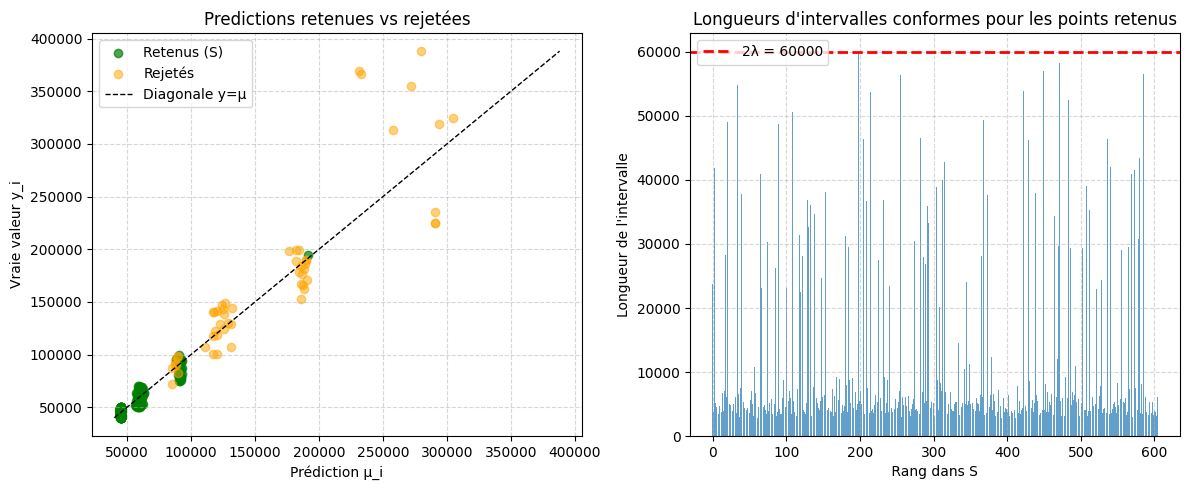

In [35]:
visualize_selection(
    y_true      = y_test.values,
    mu_pred     = mu_test_pred,
    lower       = lower,
    upper       = upper,
    S           = S,
    lambda_value= lambda_value
)

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_with_band(y_true, mu_pred, S, lambda_value):
    """
    Scatter plot mu_pred vs y_true :
      - Les points retenus (i ∈ S) en vert, les autres en gris.
      - Bande rouge transparente correspondant à y = x ± λ (largeur totale 2λ).
      - Diagonale y = x en pointillés.
    """
    m = len(y_true)
    mask = np.zeros(m, dtype=bool)
    mask[S] = True

    # Limites de l'axe pour tracer la bande
    x_min, x_max = mu_pred.min(), mu_pred.max()
    xs = np.linspace(x_min, x_max, 200)

    plt.figure(figsize=(7,7))

    # 2) diagonale y = x
    plt.plot(xs, xs, 'k--', lw=1, label='y = μ')

    # 3) scatter avec transparence & petits marqueurs
    plt.scatter(mu_pred[~mask], y_true[~mask],
                s=20, alpha=0.3, color='gray', label='Rejetés')
    plt.scatter(mu_pred[mask],  y_true[mask],
                s=20, alpha=0.6, color='green', label='Retenus (S)')

    plt.xlabel('Prédiction μ_i')
    plt.ylabel('Vraie valeur y_i')
    plt.title('Prédictions retenues vs rejetées avec bande ±λ')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


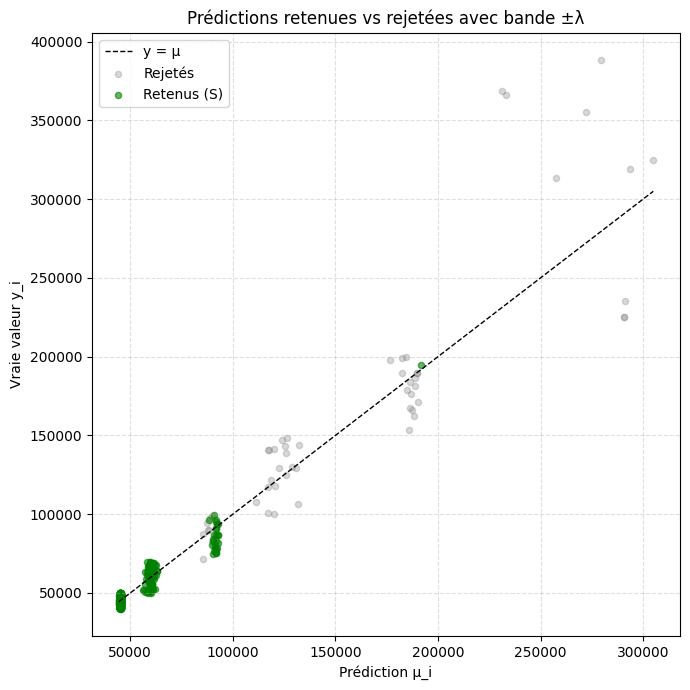

In [39]:
visualize_with_band(
    y_true      = y_test.values,
    mu_pred     = mu_test_pred,
    S           = S,
    lambda_value= lambda_value
)